# Conformal Prediction for Regression

### Loading Libraries

In [52]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Dat Visualization
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from yellowbrick.regressor import PredictionError
from matplotlib.offsetbox import AnnotationBbox, TextArea

# SciPy
from scipy.stats import rankdata
from scipy.stats import randint, uniform

#
import openml

# Notebook Opt
from tqdm import tqdm

# Crepes
from crepes import WrapRegressor
from crepes.extras import binning
from crepes.extras import DifficultyEstimator

# Mapie
from mapie.subsample import Subsample
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score

# Scikit-Learn

from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor
from  sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import label_binarize, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, confusion_matrix

# Boosting Libraries
from lightgbm import LGBMRegressor
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Conformal Libraries
from nonconformist.nc import NcFactory
from nonconformist.cp import IcpClassifier
from nonconformist.cp import TcpClassifier
from nonconformist.base import ClassifierAdapter
from nonconformist.nc import InverseProbabilityErrFunc, MarginErrFunc, ClassifierNc

### Mandatory Libraries

```sh
!pip install dtype_diet
!pip install openml
!pip install mapie
!pip install crepes
!pip install aws-fortuna
```

In [2]:
%matplotlib inline

In [3]:
random_state = 23
rng = np.random.default_rng(random_state)
round_to = 3

#### Loading Data: `https://docs.openml.org/Python-API/`

In [4]:
datasets_df = openml.datasets.list_datasets(output_format="dataframe")
print(datasets_df.head(n=10))

datasets_df.set_index('did', inplace = True)

    did             name  version uploader  status format  MajorityClassSize  \
2     2           anneal        1        1  active   ARFF              684.0   
3     3         kr-vs-kp        1        1  active   ARFF             1669.0   
4     4            labor        1        1  active   ARFF               37.0   
5     5       arrhythmia        1        1  active   ARFF              245.0   
6     6           letter        1        1  active   ARFF              813.0   
7     7        audiology        1        1  active   ARFF               57.0   
8     8  liver-disorders        1        1  active   ARFF                NaN   
9     9            autos        1        1  active   ARFF               67.0   
10   10            lymph        1        1  active   ARFF               81.0   
11   11    balance-scale        1        1  active   ARFF              288.0   

    MaxNominalAttDistinctValues  MinorityClassSize  NumberOfClasses  \
2                           7.0                8

In [5]:
datasets_df.head()

,name,version,uploader,status,format,MajorityClassSize,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures
did,,,,,,,,,,,,,,,
2,anneal,1,1,active,ARFF,684.0,7.0,8.0,5.0,39.0,898.0,898.0,22175.0,6.0,33.0
3,kr-vs-kp,1,1,active,ARFF,1669.0,3.0,1527.0,2.0,37.0,3196.0,0.0,0.0,0.0,37.0
4,labor,1,1,active,ARFF,37.0,3.0,20.0,2.0,17.0,57.0,56.0,326.0,8.0,9.0
5,arrhythmia,1,1,active,ARFF,245.0,13.0,2.0,13.0,280.0,452.0,384.0,408.0,206.0,74.0
6,letter,1,1,active,ARFF,813.0,26.0,734.0,26.0,17.0,20000.0,0.0,0.0,16.0,1.0


#### California Data Information

In [6]:
datasets_df.loc[43939]

name                                  california_housing
version                                                1
uploader                                           30861
status                                            active
format                                              ARFF
MajorityClassSize                                    NaN
MaxNominalAttDistinctValues                          NaN
MinorityClassSize                                    NaN
NumberOfClasses                                      0.0
NumberOfFeatures                                    10.0
NumberOfInstances                                20640.0
NumberOfInstancesWithMissingValues                 207.0
NumberOfMissingValues                              207.0
NumberOfNumericFeatures                              9.0
NumberOfSymbolicFeatures                             1.0
Name: 43939, dtype: object

In [7]:
dataset = openml.datasets.get_dataset(43939)

# Retrieving Summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

This is dataset 'california_housing', the target feature is 'median_house_value'
URL: https://api.openml.org/data/v1/download/22102987/california_housing.arff
Median house prices for California districts derived from the 1990 census.


In [8]:
X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

df = pd.DataFrame(X, columns=attribute_names)

df["class"] = y

#### Checking for Categorical Variables

In [9]:
categorical_indicator

[False, False, False, False, False, False, False, False, True]

In [10]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
0,-122.230003,37.880001,41.0,880.0,129.0,322.0,126.0,8.3252,3.0,452600.0
1,-122.220001,37.860001,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,3.0,358500.0
2,-122.239998,37.849998,52.0,1467.0,190.0,496.0,177.0,7.2574,3.0,352100.0
3,-122.250000,37.849998,52.0,1274.0,235.0,558.0,219.0,5.6431,3.0,341300.0
4,-122.250000,37.849998,52.0,1627.0,280.0,565.0,259.0,3.8462,3.0,342200.0


In [11]:
df['ocean_proximity'].unique()

array([3., 0., 1., 4., 2.], dtype=float32)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float32
 1   latitude            20640 non-null  float32
 2   housing_median_age  20640 non-null  float32
 3   total_rooms         20640 non-null  float32
 4   total_bedrooms      20433 non-null  float32
 5   population          20640 non-null  float32
 6   households          20640 non-null  float32
 7   median_income       20640 non-null  float32
 8   ocean_proximity     20640 non-null  float32
 9   class               20640 non-null  float64
dtypes: float32(9), float64(1)
memory usage: 887.0 KB


In [13]:
df['ocean_proximity'] = df['ocean_proximity'].astype('category')

In [14]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
ocean_proximity         0
class                   0
dtype: int64

In [15]:
df.dropna(subset=['total_bedrooms'], inplace=True)

In [16]:
y

array([452600., 358500., 352100., ...,  92300.,  84700.,  89400.])

In [17]:
# Features
X = df.drop('class', axis = 1)

# Target
y = df['class']

### Inductive Conformal Prediction

For ICP is required:

1. Splitting The Datasets into 3 Datasets: A `Traininig set`, A `Calibration` & `Test Set`

2. The Training Set is used to train the underlying model, The Calibration Set is used by Conformal Prediction & Test Set is used to Test models

In [18]:
# Splitting Procedure
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

In [19]:
# A 1000 Objects for Calibration
X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

In [20]:
# Checking Splitting Shape:
print('Data split. Parts sizes: train = {}, calib = {}, test = {}'.format(X_proper_train.shape, X_cal.shape, X_test.shape))

Data split. Parts sizes: train = (19333, 9), calib = (1000, 9), test = (100, 9)


### `Note`: 
#### The Author provides literature resources for a broader scope on `CP-ICP`. Check author's book and original repository.

### Conformal Prediction procedure: `To Explain`

### Naive Inductive Conformal Prediction Regression steps: `To Provide`

In [21]:
# Setting Model
model = RandomForestRegressor(n_jobs=-1)

# Fitting Model
model.fit(X_proper_train, y_proper_train)

RandomForestRegressor(n_jobs=-1)

In [22]:
alpha = 0.05

n_cal = len(y_cal)

n_cal

1000

In [23]:
# Point Predictions on The Calibration & Test Sets
y_pred_cal = model.predict(X_cal)

y_pred_test = model.predict(X_test)

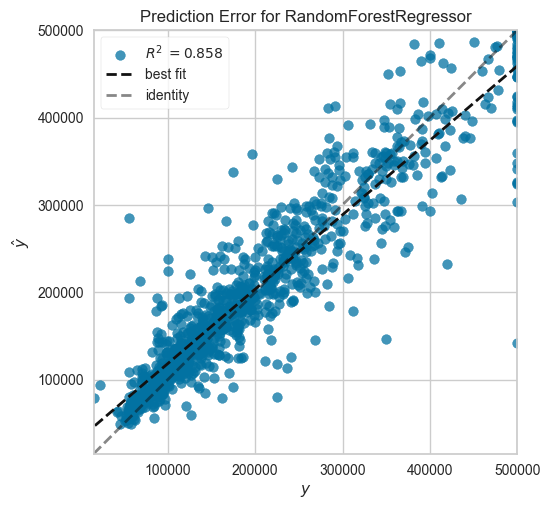

In [24]:
# Modelling Prediction Error
visualizer = PredictionError(model)

# Placing on Test set
visualizer.score(X_cal, y_cal)
visualizer.show() 
plt.show()

In [25]:
# Calibration Errors
y_cal_error = np.abs(y_cal - y_pred_cal)

In [26]:
# Quantile Calculation with Coverage Final Sample Adjustment
np.ceil((n_cal+1)*(1-alpha))/n_cal

0.951

#### # `q_hat` on Calibration Set

In [27]:
q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

q_yhat_cal

90232.53578000002

### Calibration Error

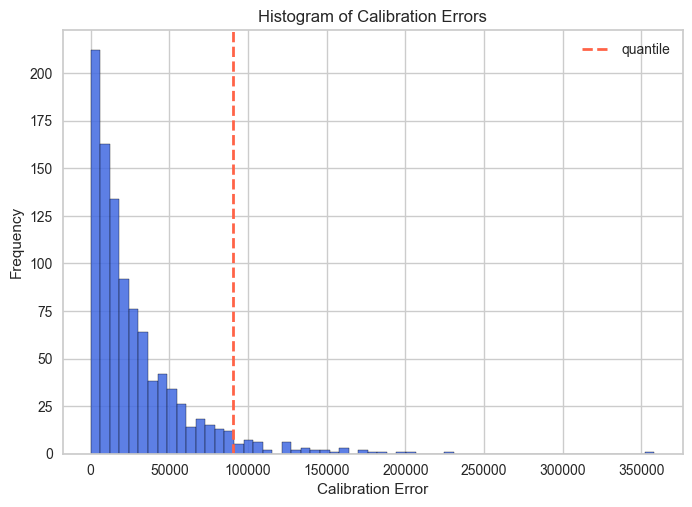

In [28]:
plt.hist(y_cal_error, bins='auto', color='royalblue', edgecolor='black', alpha=0.85)

plt.axvline(q_yhat_cal, color='tomato', linestyle='dashed', linewidth=2, label='quantile')

plt.legend()
plt.xlabel('Calibration Error')
plt.ylabel('Frequency')
plt.title('Histogram of Calibration Errors')

plt.show()

### `RandomForestRegressor` Model Prediction Error

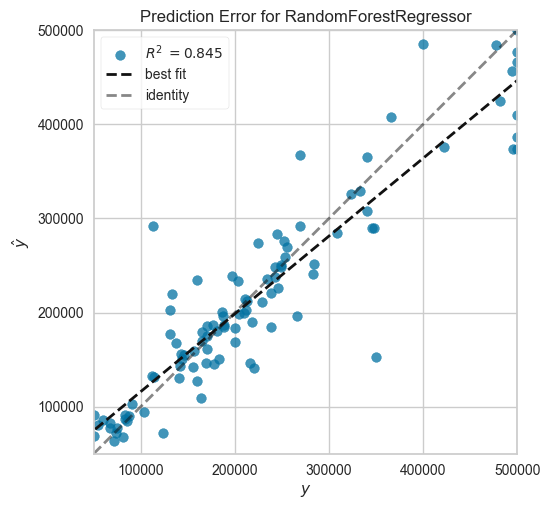

In [29]:
visualizer = PredictionError(model)

#Test Model Evaluation
visualizer.score(X_test, y_test)

# Rendering
visualizer.show()  
plt.show()

In [30]:
# Lower `yhat`
y_hat_test_lower = y_pred_test - q_yhat_cal

# Upper `yhat`
y_hat_test_upper = y_pred_test + q_yhat_cal

#### Retrieving Outcomes:

In [31]:
predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

predict_df

,actual,predicted,lower_bound,upper_bound
0,245800.0,226374.01,136141.47422,316606.54578
1,137900.0,168106.00,77873.46422,258338.53578
2,218200.0,189685.00,99452.46422,279917.53578
3,220800.0,140845.00,50612.46422,231077.53578
4,170500.0,175567.00,85334.46422,265799.53578
...,...,...,...,...
95,50000.0,69231.00,-21001.53578,159463.53578
96,500001.0,410149.29,319916.75422,500381.82578
97,55000.0,80713.00,-9519.53578,170945.53578
98,204200.0,198075.00,107842.46422,288307.53578


#### Coverage Function:

In [32]:
def calculate_coverage(df):
    df['in_interval'] = df.apply(lambda row: row['lower_bound'] <= row['actual'] <= row['upper_bound'], axis=1)
    coverage = df['in_interval'].mean()
    return coverage

coverage = calculate_coverage(predict_df)
print(f"Coverage: {coverage}")

Coverage: 0.94


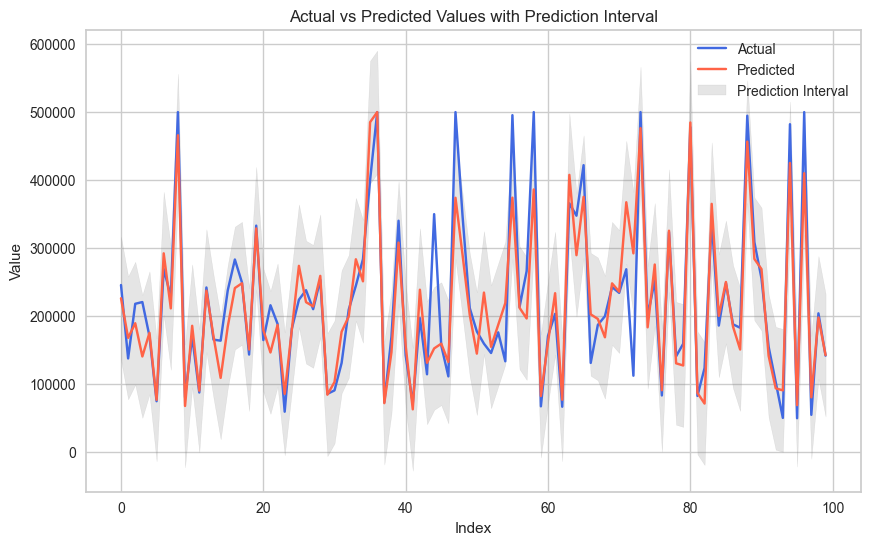

In [33]:
plt.figure(figsize=(10, 6))

# Actual Values
plt.plot(predict_df['actual'], label='Actual', color='royalblue')
# Predicted Values
plt.plot(predict_df['predicted'], label='Predicted', color='tomato')
# Prediction Intervals
plt.fill_between(predict_df.index, predict_df['lower_bound'], predict_df['upper_bound'],
                 color='gray', alpha=0.2, label='Prediction Interval')

# Legend
plt.legend(loc='upper right')
# Set labels & Title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values with Prediction Interval')

plt.show()

### Mathematical Reasoning retrieved from:

1) The `distribution of coverage` follows the following equation:
\begin{equation}
\mathbb{E}\left[1\{y \in C(x_{\text{val}})\} \, | \, \{(x_i, y_i)\}_{i=1}^{n_{\text{cal}}}\right] 
\sim \text{Beta}(n_{\text{cal}} + 1 - l, l)
\end{equation}

2) `Calculating empirical coverage` using $T$ trials and verify whether it fits the Beta distribution:
\begin{equation}
C_j = \frac{1}{n_{\text{val}}} \sum_{i=1}^{n_{\text{val}}} 1\{y_i \in C(x_{\text{val}})\}, 
\quad j \in \{1, 2, \dots, T\}.
\end{equation}


#### Trial Function, as follows:

##### 1. Splitting the datasets into 3 datasets: Proper `Training Set`, `Calibration` and `Test Set`.
   
##### 2. A proper `Training Set` is used to train the underlying model, `Calibration Set` is used by `Conformal Prediction`

##### 3. A `Test Set` is used to Test models

In [34]:
def trial_func():
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=100, shuffle = True, random_state=42)

  # 1000 Objects for Calibration
  X_proper_train, X_cal, y_proper_train, y_cal = train_test_split(X_train, y_train, test_size=1000)

  # Placing Random Forest Regressor to Train The Underlying Model
  model = RandomForestRegressor(n_jobs=-1)
  model.fit(X_proper_train, y_proper_train)

  # Getting Predictions Points on the Calibration & Test Sets
  y_pred_cal = model.predict(X_cal)
  y_pred_test = model.predict(X_test)

  # Calculating Calibration Errors
  y_cal_error = np.abs(y_cal - y_pred_cal)

  # Calculating q_hat on The Calibration Set
  q_yhat_cal = np.quantile(y_cal_error,np.ceil((n_cal+1)*(1-alpha))/n_cal)

  # ComputING Upper & Lower Bounds
  y_hat_test_lower = y_pred_test - q_yhat_cal
  y_hat_test_upper = y_pred_test + q_yhat_cal

  # Create Dataframe with Prediciton Results
  predict_df = pd.DataFrame(list(zip(y_test,y_pred_test,y_hat_test_lower,y_hat_test_upper)),
                  columns=['actual','predicted','lower_bound','upper_bound'])

  coverage = calculate_coverage(predict_df)
  return coverage

In [35]:
trial_func()

0.95

### Regression Coverage Score

In [36]:
regression_coverage_score(predict_df['actual'].values, predict_df['lower_bound'].values, predict_df['upper_bound'].values)

/Users/isisromero/anaconda3/envs/CP/lib/python3.11/site-packages/mapie/utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


0.94

In [37]:
regression_mean_width_score(predict_df['lower_bound'].values, predict_df['upper_bound'].values)

180465.07156000004

In [38]:
2*q_yhat_cal

180465.07156000004

## Conformalized Quantile Regression, Jackknife+ & more (MAPIE)

#### From Author:

1) The target variable of this dataset is the median house value for the California districts. 

2) This dataset is composed of 8 features, including ariables such as the age of the house, the median income of the neighborhood, the average numbe rooms or bedrooms or even the location in latitude and longitude. In total there are around 20k observations.

In [39]:
pear_corr = df.corr(method='pearson')

pear_corr.style.background_gradient(cmap='Greens', axis=0)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,class
longitude,1.000000,-0.924616,-0.109357,0.045480,0.069608,0.100270,0.056513,-0.015550,-0.289530,-0.045398
latitude,-0.924616,1.000000,0.011899,-0.036667,-0.066983,-0.108997,-0.071774,-0.079626,0.200801,-0.144638
housing_median_age,-0.109357,0.011899,1.000000,-0.360628,-0.320451,-0.295787,-0.302768,-0.118278,0.112330,0.106432
total_rooms,0.045480,-0.036667,-0.360628,1.000000,0.930380,0.857281,0.918992,0.197882,-0.015363,0.133294
total_bedrooms,0.069608,-0.066983,-0.320451,0.930380,1.000000,0.877747,0.979728,-0.007723,-0.014768,0.049686
population,0.100270,-0.108997,-0.295787,0.857281,0.877747,1.000000,0.907186,0.005087,-0.069630,-0.025300
households,0.056513,-0.071774,-0.302768,0.918992,0.979728,0.907186,1.000000,0.013434,-0.018251,0.064894
median_income,-0.015550,-0.079626,-0.118278,0.197882,-0.007723,0.005087,0.013434,1.000000,-0.014679,0.688355
ocean_proximity,-0.289530,0.200801,0.112330,-0.015363,-0.014768,-0.069630,-0.018251,-0.014679,1.000000,0.080488
class,-0.045398,-0.144638,0.106432,0.133294,0.049686,-0.025300,0.064894,0.688355,0.080488,1.000000


#### Housing Prices Bins

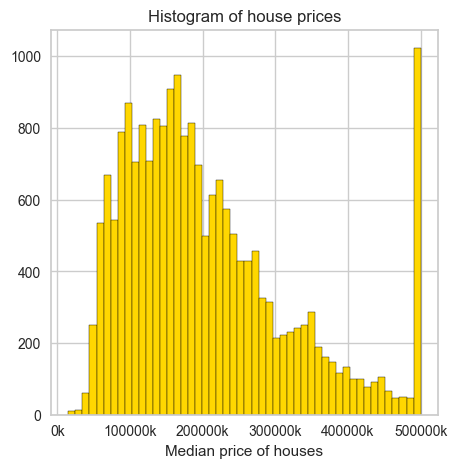

In [48]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.hist(y, bins=50, edgecolor='black', color='gold')
axs.set_xlabel("Median price of houses")
axs.set_title("Histogram of house prices")
axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
plt.show()

#### Optimize Underlying Model

In [53]:
# Placing Estimator (Light Gradient Boosting Regressor)
estimator = LGBMRegressor(objective='quantile', alpha=0.5, random_state=random_state)

# Parameter Distribution
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=300),
    learning_rate=uniform()
)

# Model Optimization
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=100,
    cv=KFold(n_splits=5, shuffle=True),
    verbose=0
)

# Fitting Model
optim_model.fit(X_train, y_train)

# Getting Best Estimator
estimator = optim_model.best_estimator_

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 16266, number of used features: 9
[LightGBM] [Info] Start training from score 179600.000000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1843
[LightGBM] [Info] Number of data points in the train set: 16266, number of used features: 9
[LightGBM] [Info] Start training from score 179500.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB